## Prerequisites

In [39]:
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers
import os, re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

In [3]:
# Set data directory
PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"

In the parent folder, the data are organized as follows:

```
PARENT_FOLDER
└───pp001
│   └───imu
│       │   imu_backwards.mat
│       │   imu_balance_sbs.mat
│       │   ...
│   └───optical
│       │   omc_backwards.mat
│       │   omc_balance_sbs.mat
│       │   ...
└───pp002
│   └───imu
│       │   imu_backwards.mat
│       │   imu_balance_sbs.mat
│       │   ...
│   └───optical
│       │   omc_backwards.mat
│       │   omc_balance_sbs.mat
│       │   ...
└───...
```

In [7]:
# Get a list of folders, each folder corresponds to a participant id
participant_ids = [pid for pid in os.listdir(PARENT_FOLDER) if pid.startswith("pp")]
print(participant_ids)

['pp001', 'pp002', 'pp003', 'pp004', 'pp005', 'pp006', 'pp007', 'pp008', 'pp009', 'pp011', 'pp012', 'pp013', 'pp014', 'pp015', 'pp016', 'pp018', 'pp019', 'pp020', 'pp021', 'pp022', 'pp023', 'pp025', 'pp026', 'pp027', 'pp028', 'pp029', 'pp030', 'pp031', 'pp032', 'pp033', 'pp035', 'pp036', 'pp037', 'pp038', 'pp039', 'pp040', 'pp041', 'pp042', 'pp044', 'pp045', 'pp046', 'pp047', 'pp048', 'pp049', 'pp050', 'pp051', 'pp052', 'pp053', 'pp054', 'pp055', 'pp058', 'pp059', 'pp060', 'pp061', 'pp062', 'pp063', 'pp064', 'pp065', 'pp066', 'pp067', 'pp068', 'pp069', 'pp070', 'pp071', 'pp072', 'pp073', 'pp074', 'pp075', 'pp076', 'pp077', 'pp078', 'pp079', 'pp080', 'pp081', 'pp082', 'pp083', 'pp084', 'pp085', 'pp086', 'pp087', 'pp088', 'pp089', 'pp090', 'pp091', 'pp093', 'pp094', 'pp095', 'pp096', 'pp097', 'pp098', 'pp099', 'pp100', 'pp101', 'pp102', 'pp103', 'pp104', 'pp105', 'pp106', 'pp107', 'pp108', 'pp109', 'pp110', 'pp111', 'pp112', 'pp113', 'pp114', 'pp115', 'pp116', 'pp117', 'pp118', 'pp119']


In [8]:
# For each participant id
for pid in participant_ids[:1]:

    # Get a list of IMU data files
    imu_files = [fname for fname in os.listdir(os.path.join(PARENT_FOLDER, pid, "imu")) if fname.endswith(".mat")]
print(imu_files)

['imu_backwards.mat', 'imu_balance_sbs.mat', 'imu_balance_semi.mat', 'imu_balance_tandem.mat', 'imu_calibration_1.mat', 'imu_calibration_2.mat', 'imu_calibration_3.mat', 'imu_calibration_4.mat', 'imu_chairrise_fast.mat', 'imu_chairrise_preferred.mat', 'imu_choreo.mat', 'imu_gait1.mat', 'imu_gait2.mat', 'imu_home_part1.mat', 'imu_home_part2.mat', 'imu_obstacle_high.mat', 'imu_obstacle_low.mat', 'imu_reaction.mat', 'imu_sideways.mat', 'imu_slalom.mat', 'imu_splitbelt_left.mat', 'imu_stroop.mat', 'imu_tug.mat', 'imu_updrs3_1.mat', 'imu_walk_fast.mat', 'imu_walk_preferred.mat', 'imu_walk_reaction.mat', 'imu_walk_slow.mat', 'imu_walk_stroop.mat', 'imu_walk_turn.mat']


## Load data
Let us load the data from the inertial measurement units from the 5 meter walk trial, at preferred walking speed.

In [10]:
# Set the filename
my_filename = "imu_walk_preferred.mat"

# Call
data = _load_file(os.path.join(PARENT_FOLDER, pid, "imu", my_filename))

In [12]:
print(data.keys())

dict_keys(['calibration_file', 'acc', 'gyro', 'magn', 'fs', 'imu_location'])


In [29]:
print(data["imu_location"])

['head' 'sternum' 'left_upper_arm' 'left_fore_arm' 'right_upper_arm'
 'right_fore_arm' 'pelvis' 'left_thigh' 'left_shank' 'left_foot'
 'right_thigh' 'right_shank' 'right_foot' 'left_ankle' 'right_ankle'
 'pocket']


## Plot data
Let us plot some data, for example the gyroscope data from the left and right ankle sensor.

In [28]:
# Set sensor name
my_sensors = ["left_ankle", "right_ankle"]

# Get the corresponding indexes
ixs = [np.argwhere(data["imu_location"]==s)[:,0][0] for s in my_sensors]
print(ixs)

[13, 14]


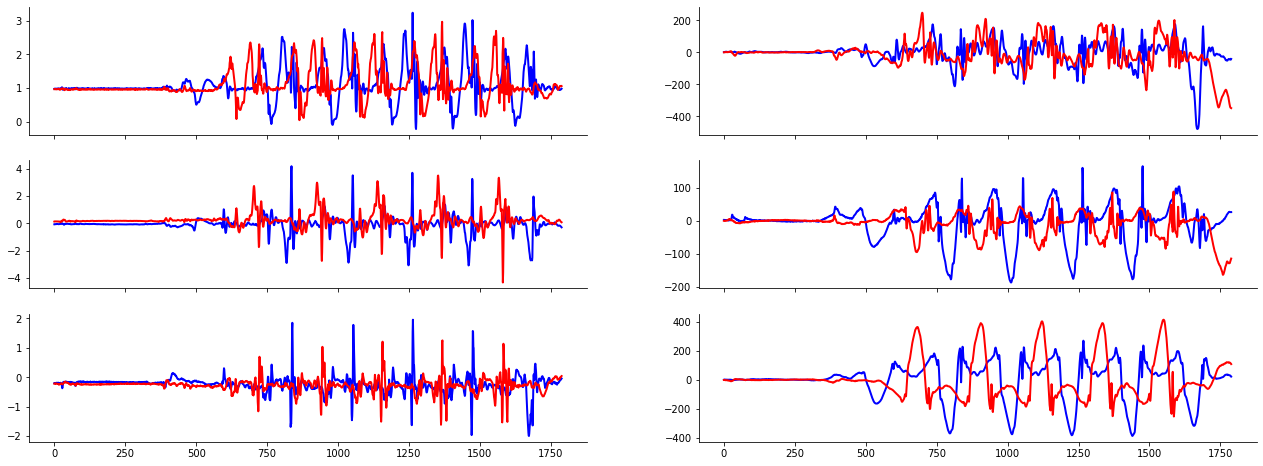

In [43]:
# Create figure
fig, axs = plt.subplots(3, 2, figsize=(22, 8), sharex=True)
for ix in ixs:
    if "left_" in data["imu_location"][ix]:
        clr = "b"
    else:
        clr = "r"

    # Plot accelerometer data
    acc = data["acc"][:,:,ix]
    for idim in range(acc.shape[1]):
        axs[idim,0].plot(acc[:,idim], '-', c=clr, lw=2)

    # Plot gyroscope data
    gyro = data["gyro"][:,:,ix]
    for idim in range(gyro.shape[1]):
        axs[idim,1].plot(gyro[:,idim], '-', c=clr, lw=2)
